In [293]:
import numpy as np
import pandas as pd
import pingouin as pg
import plotly_express as px
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler 


df = pd.read_csv("football.csv")

# Preprocessing

In [294]:
df["Start Season"] = df["Season"].apply(lambda x : int(x[:4]))
df["End Season"] = df["Season"].apply(lambda x : int(x[5:]))
df["League"].replace('La Liga', 'La_liga',inplace = True)
df["League"].replace('Premier League', 'EPL',inplace = True)

year = 2019

df_understat = pd.read_csv("understat.com.csv")
df_understat.rename(columns = {
    "Unnamed: 0" : "league",
    "Unnamed: 1" : "season",
    "position" : "rank"
    }, inplace = True)
pl_u = df_understat[(df_understat["league"] == "EPL") & (df_understat["season"] == year)][["rank","team", "npxGD"]].sort_values(["rank"]).reset_index(drop = True)
ll_u = df_understat[(df_understat["league"] == "La_liga") & (df_understat["season"] == year)][["rank","team", "npxGD"]].sort_values(["rank"]).reset_index(drop = True)


pl = df[(df["Start Season"] == year) & ((df["League"] == 'EPL') )][['Rank','League','Team','Possession','ShortPassesPerGame', 'LongBallsPerGame']].sort_values(["Rank"]).reset_index(drop = True)
# SPPLBP - ShortPassesPerGameDividedbyLongBallsPerGame
# SPPLBP more - means your teams more prefer to play on the pitch instead of the sky :D
pl["SPPLBP"] = pl["ShortPassesPerGame"] /pl["LongBallsPerGame"]
pl.drop(["LongBallsPerGame", "ShortPassesPerGame"], axis = 1, inplace = True)
pl["Rank"] = pl["Rank"].astype(int)
pl["npxGD"] = pl_u["npxGD"]


ll = df[(df["Start Season"] == year) & ((df["League"] == 'La_liga') )][['Rank','League','Team','Possession','ShortPassesPerGame', 'LongBallsPerGame']].sort_values(["Rank"]).reset_index(drop = True)
ll["SPPLBP"] = ll["ShortPassesPerGame"] /ll["LongBallsPerGame"]
ll.drop(["LongBallsPerGame", "ShortPassesPerGame"], axis = 1, inplace = True)
ll["Rank"] = ll["Rank"].astype(int)
ll["npxGD"] = ll_u["npxGD"]

pl_ll = pd.concat([pl,ll]).reset_index(drop = True)

Possession, 

npxGD - difference between "for" and "against" expected goals without penalties and own goals

ShortPassesPerGame / LongBallsPerGame

Davandegi

In [295]:
pl_ll.head()

,Rank,League,Team,Possession,SPPLBP,npxGD
0,1,EPL,Liverpool,59.6,8.590909,32.575792
1,2,EPL,Manchester City,62.6,12.169811,58.818903
2,3,EPL,Manchester United,54.6,9.836735,19.754725
3,4,EPL,Chelsea,57.9,9.807018,31.333631
4,5,EPL,Leicester,55.1,8.600000,15.391501


In [296]:
pl_ll.tail()

,Rank,League,Team,Possession,SPPLBP,npxGD
35,16,La_liga,Deportivo Alaves,43.2,3.984848,-13.093103
36,17,La_liga,Celta Vigo,51.3,7.200000,-7.361762
37,18,La_liga,Leganes,45.0,4.164179,-5.268822
38,19,La_liga,Mallorca,46.3,5.888889,-20.254996
39,20,La_liga,Espanyol,47.5,4.571429,-13.886380


In [297]:
scaler = MinMaxScaler()
pl_ll[["Possession","SPPLBP","npxGD"]] = scaler.fit_transform(pl_ll[["Possession","SPPLBP","npxGD"]])

In [298]:
pl_ll.head()

,Rank,League,Team,Possession,SPPLBP,npxGD
0,1,EPL,Liverpool,0.924686,0.510146,0.705905
1,2,EPL,Manchester City,0.987448,0.824368,1.000000
2,3,EPL,Manchester United,0.820084,0.619527,0.562225
3,4,EPL,Chelsea,0.889121,0.616918,0.691985
4,5,EPL,Leicester,0.830544,0.510944,0.513329


In [299]:
overview = px.scatter_3d(pl_ll, x = 'Possession', y = 'SPPLBP', z = 'npxGD', hover_name = 'Team')
overview.show()

# KMeans Clustering 

In [300]:
n = 3
kmeans_n3 = KMeans(n_clusters = n, max_iter = 300)
kmeans_n3.fit(pl_ll[["Possession","SPPLBP","npxGD"]])
pl_ll["cluster"] = kmeans_n3.labels_
kmeans_n3_fig = px.scatter_3d(pl_ll, x = 'Possession', y = 'SPPLBP', z = 'npxGD', hover_name = 'Team', color = 'cluster', title = 'n = 3')
kmeans_n3_fig.show()

## Tuning

In [301]:
distortions = []
K = range(1, 10)

for k in K:
	kmeanModel = KMeans(n_clusters=k)
	kmeanModel.fit(pl_ll[["Possession","SPPLBP","npxGD"]])

	
	cdist_result = cdist(pl_ll[["Possession","SPPLBP","npxGD"]], kmeanModel.cluster_centers_,'euclidean')
	minimum_cdist = np.min(cdist_result, axis = 1)
	sum_minimum_cdsit = np.sum(minimum_cdist)
	avg_cdist = sum_minimum_cdsit / pl_ll.shape[0]

	distortions.append(avg_cdist)

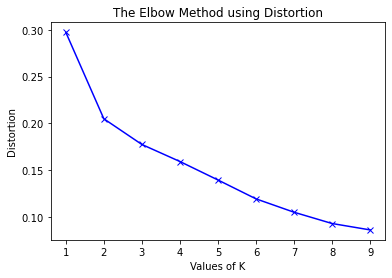

In [302]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

## Final KMeans

In [304]:
n = 6
kmeans_n6 = KMeans(n_clusters = n, max_iter = 3000)
kmeans_n6.fit(pl_ll[["Possession","SPPLBP","npxGD"]])
pl_ll["cluster"] = kmeans_n6.labels_
kmeans_n6_fig = px.scatter_3d(pl_ll, x = 'Possession', y = 'SPPLBP', z = 'npxGD', hover_name = 'Team', color = 'cluster', title = f'Clustering EPL & La Liga Teams (kmean method, n = {n})')
kmeans_n6_fig.show()